# Pretrained ML models on Sentinel-2 Images

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import os

In [3]:
path = os.getcwd()
path

'/home/jupyter/satellite'

In [4]:
df = pd.read_csv('Level1_labels.csv', header=None, sep='|')
#df1 = df.head(100000)
#df1.head()

In [5]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2)

data = ImageDataBunch.from_df(path,
                              df,
                              folder='../data/rgb',suffix='.png',
                              label_delim=';',
                              bs=256,
                              seed=42,
                              valid_pct=0.2,
                              ds_tfms=tfms,
                              size=120).normalize(imagenet_stats)

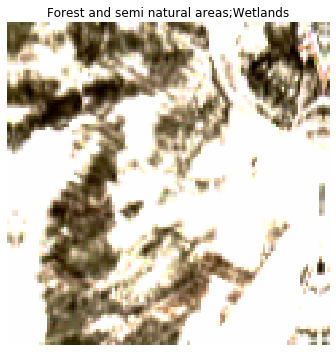

In [6]:
data.show_batch(rows=1, figsize=(5,5))

In [7]:
# Metrics
acc_02 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)

# Create cnn with the resnet50 architecture
learner = cnn_learner(data, models.resnet50, metrics=[acc_02,f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


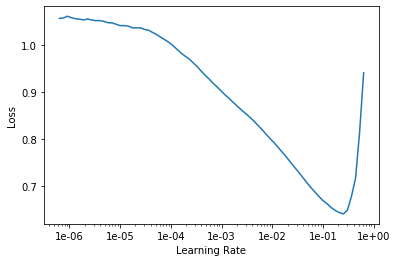

In [8]:
learner.lr_find()
learner.recorder.plot()

In [9]:
lr = 1e-2

In [10]:
#Add callback_fns to Learner for logging
learner.callback_fns.append(partial(CSVLogger,filename='Level1', append=True))
learner.callback_fns.append(ShowGraph)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.208032,0.191013,0.921532,0.901763,09:20
1,0.187429,0.169925,0.930779,0.913445,09:20
2,0.180387,0.166343,0.929592,0.916613,09:20
3,0.174492,0.160896,0.932188,0.921288,09:21
4,0.172528,0.156468,0.936530,0.916972,09:20
5,0.168500,0.155538,0.933586,0.924087,09:20
6,0.163526,0.151313,0.937042,0.922401,09:21
7,0.161472,0.147104,0.939441,0.925310,09:21
8,0.157695,0.145378,0.939648,0.926876,09:21
9,0.157320,0.145146,0.940012,0.926771,09:20


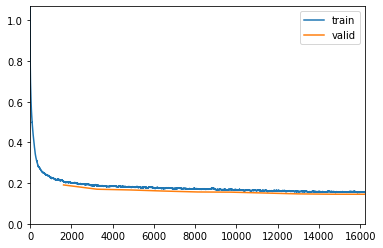

In [11]:
learner.fit_one_cycle(10, slice(lr))

In [12]:
learner.save('Level1_stage-1-rn50')

In [11]:
#learner.load('Level1_stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Arable land;Heterogeneous agricultural areas;Pastures;Forests,Scrub and/or herbaceous vegetation associations;Forests,Marine waters,Forests;Urban fabric;Heterogeneous agricultural areas,Inland waters;Forests
Path: /home/jupyter/satellite;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Scrub and/or herbaceous vegetation associations;Industrial, commercial and transport units;Pastures,Arable land;Heterogeneous agricultural areas;Pastures;Urban fabric;Forests,Scrub and/or herbaceous vegetation associations;Arable land,Arable land;Pastures,Scrub and/or herbaceous vegetation associations;Arable land;Inland waters;Forests
Path: /home/jupyter/satellite;

Test: None, model=Sequential

In [13]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


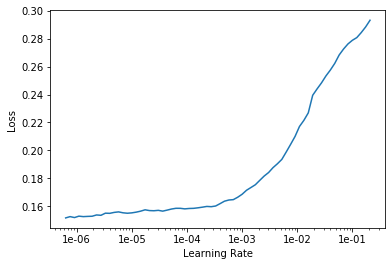

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.156431,0.144903,0.940110,0.926416,12:03
1,0.155461,0.144212,0.940717,0.926983,12:00
2,0.151979,0.141531,0.941196,0.929035,12:02
3,0.151202,0.140252,0.941974,0.929017,12:04
4,0.151017,0.140346,0.941616,0.929535,12:04


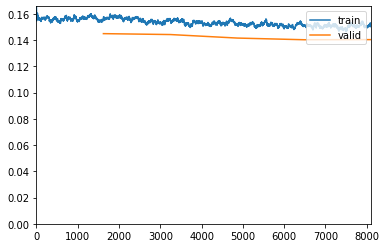

In [16]:
learner.fit_one_cycle(5, slice(lr, lr/5))

In [17]:
learner.save('Level1-stage-2-rn50')

In [8]:
learner.load('Level1-stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Forest and semi natural areas;Agricultural areas,Forest and semi natural areas,Artificial surfaces;Forest and semi natural areas;Agricultural areas,Forest and semi natural areas;Agricultural areas,Forest and semi natural areas;Water bodies
Path: /home/jupyter/satellite;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Artificial surfaces;Agricultural areas,Water bodies,Artificial surfaces;Agricultural areas,Forest and semi natural areas;Wetlands,Forest and semi natural areas;Agricultural areas
Path: /home/jupyter/satellite;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d

In [18]:
torch.save(learner.model[0].state_dict(), 'models/Level1_stage-2-rn50.h5')

### Analysis

In [9]:
#interp = ClassificationInterpretation.from_learner(learner)
interp = learner.interpret()

In [9]:
#losses,idxs = interp.top_losses(data.c)

#len(data.valid_ds)==len(losses)==len(idxs)

In [10]:
#len(data.valid_ds),len(losses), len(idxs)

In [11]:
#idxs

In [2]:
#interp.plot_multi_top_losses??

863 misclassified samples over 103867 samples in the validation set.


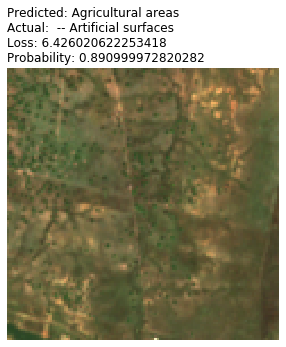

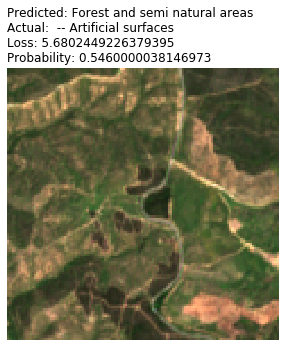

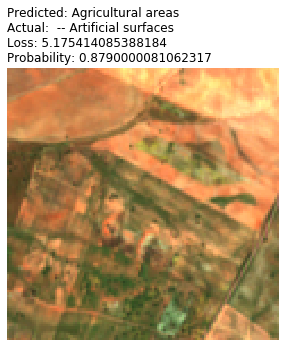

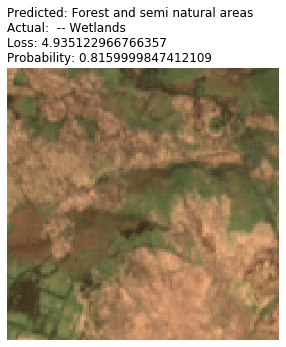

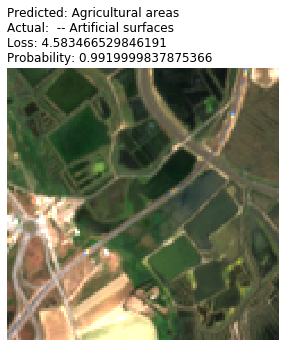

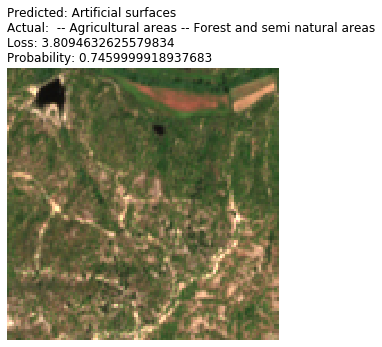

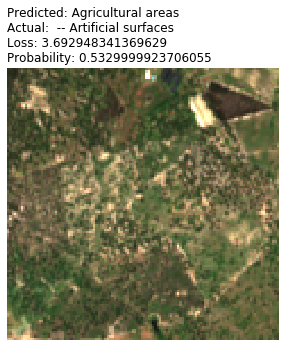

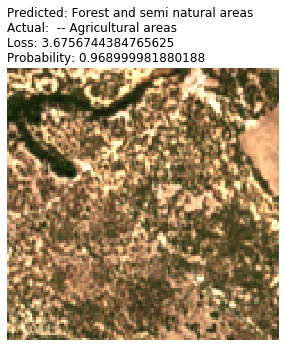

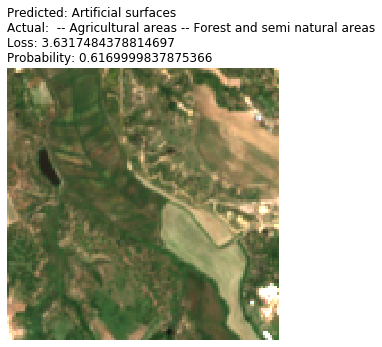

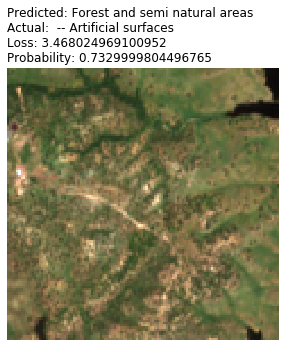

In [25]:
#misclassifieds = interp.plot_multi_top_losses(20, figsize=(5,5), save_misclassified=True)
interp.plot_multi_top_losses(10, figsize=(5,5))

In [11]:
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes

In [12]:
len(misclassifieds)

863

In [13]:
data.classes

['Agricultural areas',
 'Artificial surfaces',
 'Forest and semi natural areas',
 'Water bodies',
 'Wetlands']

In [23]:
learner.predict(misclassifieds[1])

(MultiCategory Agricultural areas;Forest and semi natural areas,
 tensor([1., 0., 1., 0., 0.]),
 tensor([0.5102, 0.3697, 0.5461, 0.0070, 0.0016]))

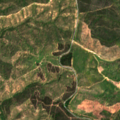

In [24]:
misclassifieds[1]